In [1]:

from utils import *
from temp_preprocessing import convert_mel_spect_librosa_only
import librosa


In [2]:
eeg_file = '/Users/imdohyeon/Library/CloudStorage/GoogleDrive-dhlim1598@gmail.com/공유 드라이브/4N_PKNU/BXAI/BMI/Mel-ResNet/Voice/Raw/Call/call1.wav'
model_path = '/Users/imdohyeon/Documents/PythonWorkspace/Mel-ResNet/Model/model_sample.pth'  # not completed yet

In [11]:
mel1 = temp_preprocessing.convert_mel_spect(slice1, sampling_rate)
mel2 = temp_preprocessing.convert_mel_spect(slice2, sampling_rate)
mel3 = temp_preprocessing.convert_mel_spect(slice3, sampling_rate)

/Users/imdohyeon/Documents/PythonWorkspace/Mel-ResNet/Preprocessing/temp_preprocessing.py:28: FutureWarning: Pass y=[ 0.         -0.00094604 -0.00088501 ... -0.01460266 -0.02062988
 -0.02636719] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spect = librosa.feature.melspectrogram(data, sr=sampling_rate)
/Users/imdohyeon/Documents/PythonWorkspace/Mel-ResNet/Preprocessing/temp_preprocessing.py:28: FutureWarning: Pass y=[-0.02896118 -0.03138733 -0.03529358 ...  0.00073242  0.00073242
  0.00056458] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spect = librosa.feature.melspectrogram(data, sr=sampling_rate)
/Users/imdohyeon/Documents/PythonWorkspace/Mel-ResNet/Preprocessing/temp_preprocessing.py:28: FutureWarning: Pass y=[ 0.00045776  0.00056458  0.00067139 ... -0.0005188  -0.0007782
 -0.00074768] as keyword args. From version 0.10 passing these as positional arguments will result

In [12]:
mel1

array([[-36.40976 , -32.695045, -35.46109 , ..., -33.79399 , -31.062634,
        -24.710196],
       [-31.835512, -30.326298, -30.766499, ..., -37.905434, -32.15899 ,
        -21.738281],
       [-30.366518, -25.09618 , -26.221134, ..., -34.37338 , -36.603455,
        -23.357351],
       ...,
       [-80.      , -77.91029 , -76.832184, ..., -76.55861 , -75.79985 ,
        -65.180084],
       [-80.      , -78.80261 , -79.01576 , ..., -78.54387 , -76.07998 ,
        -65.14513 ],
       [-80.      , -80.      , -80.      , ..., -79.43901 , -77.64453 ,
        -65.35738 ]], dtype=float32)

In [14]:
import matplotlib.pyplot as plt
import librosa.display

def temp_plot_mel_spectrogram(data, sampling_rate):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(data, sr=sampling_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

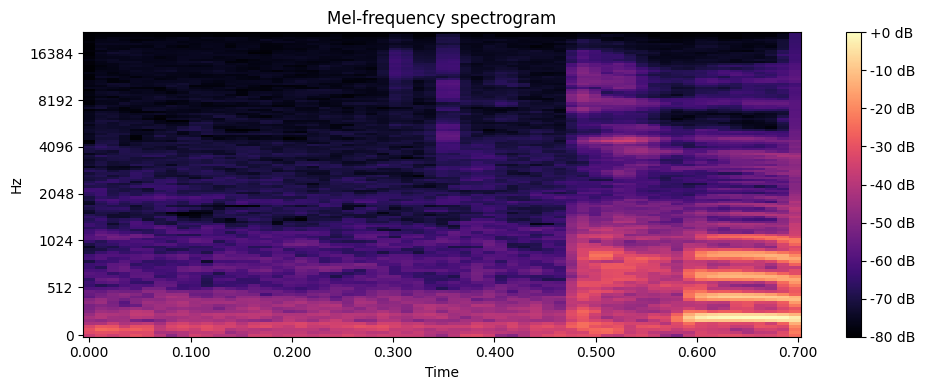

In [15]:
spect1 = temp_plot_mel_spectrogram(mel1, sampling_rate)

In [3]:
# 학습된 모델 로드
import torch
import torchvision.models as models

def load_model(model_path):
    """
    지정된 경로에서 커스텀 ResNet50 모델을 로드합니다.

    :param model_path: 모델 파일 경로
    :return: 모델 객체
    """
    # Load the ResNet50 model pre-trained on ImageNet
    model = models.resnet50(weights=False)

    # Modify the final fully connected layer to have 13 output classes
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 13)

    # Load the model state dictionary from the file
    # model.load_state_dict(torch.load(model_path))

    return model

model = load_model(model_path)

/Users/imdohyeon/miniconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:


def predict(model, raw_data, sampling_rate, device):
    """
    새로운 데이터를 분류하는 함수

    :param model: 사전 학습된 모델
    :param file_path: 예측할 음성 데이터 파일 경로
    :param device: 예측 수행 디바이스(cuda or cpu)
    :return: 예측된 라벨
    """
    # 데이터 전처리
    # data = preprocess_audio(file_path)  # 전처리 함수 사용
    data = convert_mel_spect_librosa_only(raw_data, sampling_rate)

    # Mel-spectrogram 데이터 차원 맞추기 (채널 차원 추가)
    data = np.expand_dims(data, axis=0)
    # ResNet은 3채널 입력을 기대하므로, 데이터를 3채널로 복제
    data = np.repeat(data, 3, axis=0)

    # Tensor로 변환
    data = torch.tensor(data, dtype=torch.float32)
    data = data.unsqueeze(0)  # 배치 차원 추가

    # 모델을 평가 모드로 설정
    model.eval()
    model.to(device)

    with torch.no_grad():
        data = data.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)

    # 라벨 맵핑 사전 정의
    label_map = {
        0: 'Call', 1: 'Camera', 2: 'Down', 3: 'Left', 4: 'Message', 5: 'Music', 6: 'Off',
        7: 'On', 8: 'Receive', 9: 'Right', 10: 'Turn', 11: 'Up', 12: 'Volume'
    }

    return label_map[preds.item()]

In [8]:
sampling_rate = 44100
data = librosa.load(eeg_file, sampling_rate)

# 버퍼 초기화
output_buffer = []

data_length = len(data)
window_size = data_length // 3


# EEG 데이터 시퀀스를 윈도우로 순회하며 분류
window_size = int(data_length * 0.4)
step_size = int((data_length - window_size) / 2)

start = 0
    
for _ in range(3):
    end = start + window_size
    sliced_data = np.array(data[start:end])
    
    # 전처리 및 예측
    output = predict(model, sliced_data, sampling_rate, device='cpu')
    
    # 저장 후 다음 윈도우로
    output_buffer.append(output)
    start += step_size


# 최종 결과 출력
print("Predicted classes for each window:", output_buffer)

Predicted classes for each window: ['Up', 'Up', 'Up']


/Users/imdohyeon/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


In [36]:
# 버퍼 초기화
output_buffer = []
data_length = len(data)

# EEG 데이터 시퀀스를 윈도우로 순회하며 분류
window_size = int(data_length * 0.4)
step_size = int((data_length - window_size) / 2)

start = 0

for _ in range(3):
    end = start + window_size
    sliced_data = data[start:end]
    print(len(sliced_data))  # 임시 테스트
    
    # 예측
    output = predict(model, sliced_data, device='cpu')
    
    # 저장 후 다음 윈도우로
    output_buffer.append(output)
    start += step_size

37220
37220
37220


In [37]:
len(data)

93051

In [ ]:
def main():
    eeg_file = '/Users/imdohyeon/Library/CloudStorage/GoogleDrive-dhlim1598@gmail.com/공유 드라이브/4N_PKNU/BXAI/BMI/Mel-ResNet/Voice/Raw/Call/call1.wav'
    model_path = '/Users/imdohyeon/Documents/PythonWorkspace/Mel-ResNet/Model/model_sample.pth'  # not completed yet
    
    # EEG 데이터 및 모델 로드 (EEG preprocessing 완성 전까지는 wav 파일로 대체)
    sampling_rate = 44100
    data = librosa.load(eeg_file, sr=sampling_rate)
    model = load_model(model_path)
    
    # 버퍼 초기화
    output_buffer = []
    data_length = len(data)
    
    # EEG 데이터 시퀀스를 윈도우로 순회하며 분류
    window_size = int(data_length * 0.4)
    step_size = int((data_length - window_size) / 2)
    start = 0
    
    # 윈도우 순회 시작
    for _ in range(3):
        end = start + window_size
        sliced_data = data[start:end]
        
        # 전처리 및 예측
        output = predict(model, sliced_data, device='cpu')
        
        # 결과값 버퍼에 저장 후 다음 윈도우로
        output_buffer.append(output)
        start += step_size
    
    
    # 최종 결과 출력
    print("Predicted classes for each window:", output_buffer)